In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from torch2trt import torch2trt

# Part 1: 
回帰モデル学習

最初は、データセットを読み取るための`XYDataset`クラスを定義する。

In [2]:
def get_x(path, width):
    """Gets the x value from the image filename"""
    return (float(int(path.split("_")[1])) - width/2) / (width/2)

def get_y(path, height):
    """Gets the y value from the image filename"""
    return (float(int(path.split("_")[2])) - height/2) / (height/2)

class XYDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        image = PIL.Image.open(image_path)
        width, height = image.size
        x = float(get_x(os.path.basename(image_path), width))
        y = float(get_y(os.path.basename(image_path), height))
      
        if float(np.random.rand(1)) > 0.5:
            image = transforms.functional.hflip(image)
            x = -x
        
        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, torch.tensor([x, y]).float()
    
dataset = XYDataset('dataset_xy', random_hflips=False)

そして、学習用と検証用のデータセットを`DataLoader`に渡す。

In [3]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

これからモデルのお構築に入る。

最初に、学習済みの`ResNet18`のモデルをおダウンロードして、最後のレイヤーを２出力の`torch.nn.Linear`を変換する。

できたモデルをCUDAデバイス(GPU)に移動する。

In [4]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

各エポック、学習ループと検証ループを行う。

学習ループでは、学習データをモデルを与え、モデルはラベルを予測できるようにチューニングする。

検証ループでは、データをモデルに与え、モデル精度を計算する。

一番精度が高い（ロスが低い）モデルを、`best_steering_model.pth`として保存する。

In [5]:
NUM_EPOCHS = 70
BEST_MODEL_PATH = 'best_steering_model_xy.pth'
best_loss = 1e9

train_losses = []
test_losses = []

optimizer = optim.Adam(model.parameters())

for epoch in range(NUM_EPOCHS):
    
    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    
    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    display.clear_output(wait = True)
    plt.plot(train_losses, label = 'Training Loss')
    plt.plot(test_losses, label = 'Test Loss')
    plt.legend()
    display.display(plt.gcf())
    
    plt.clf()
    
    print('epoch %d: %f, %f' % (epoch, train_loss, test_loss))
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss

<Figure size 432x288 with 0 Axes>

最後に、Pytorch形式のモデルを NVIDIA の TensorRT 形式のモデルに変形する。

そのために、`torch2trt`というライブラリーを使う。

前のセルでできたモデルを一旦ロードして、変形を行う。

最終的のモデルを`best_steering_model_xy_trt.pth`として保存する。

In [ ]:
# load the best model
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model = model.cuda().eval().half()
model.load_state_dict(torch.load('best_steering_model_xy.pth'))

device = torch.device('cuda')

# prepare empty input 
data = torch.zeros((1, 3, 224, 224)).cuda().half()

# Convert Pytorch model to TensorRT
model_trt = torch2trt(model, [data], fp16_mode=True)

torch.save(model_trt.state_dict(), 'best_steering_model_xy_trt.pth')

# Part 2: 
分類モデル学習

データセットを `torchvision.datasets` と`torchvision.utils`を使って読み取る。

In [2]:
dataset = datasets.ImageFolder(
    'dataset',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

test_num = int(0.1*len(dataset))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_num, test_num])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

ResNet18 をダウンロードして、最後のレイヤー（fc）だけを入れ替える。

最終的に、2クラス（障害物あり、障害物なし）を予測します。

In [3]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

最後に、`torch.optim.Adam`で ResNet の重みを最適化する。

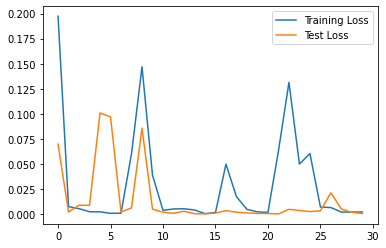

epoch 29: 0.002107, 0.000546


<Figure size 432x288 with 0 Axes>

In [4]:
NUM_EPOCHS = 30
BEST_MODEL_PATH = 'best_collision_model_resnet18.pth'
best_loss = 1e4

test_losses = []
train_losses = []

optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(NUM_EPOCHS):
    
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
    train_loss /= len(train_loader)
    
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    display.clear_output(wait= True)
    plt.plot(train_losses, label = 'Training Loss')
    plt.plot(test_losses, label = 'Test Loss')
    plt.legend()
    display.display(plt.gcf())
    
    plt.clf()

    print('epoch %d: %f, %f' % (epoch, train_loss, test_loss))
    if test_loss <= best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss

In [5]:
# load the best model
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model = model.cuda().eval().half()
model.load_state_dict(torch.load('best_collision_model_resnet18.pth'))

device = torch.device('cuda')

# prepare empty input 
data = torch.zeros((1, 3, 224, 224)).cuda().half()

# Convert Pytorch model to TensorRT
model_trt = torch2trt(model, [data], fp16_mode=True)

torch.save(model_trt.state_dict(), 'best_collision_model_resnet18_trt.pth')